**Student name: Giorgi Guledani**

**Student ID: 20193667**

# Lecture 5: Research 2: Will personalized Long Tail items further improve the recommender system?

This notebook builds upon the previous research question: "How to address the Long Tail Problem?".

In [171]:
import pandas as pd
import utils
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

articles = pd.read_parquet(f'{utils.path}/articles.parquet')
customers = pd.read_parquet(f'{utils.path}/customers.parquet')
transactions = pd.read_parquet(f'{utils.path}/transactions_train.parquet')

# Parameters

In [172]:
# amount of items to replace Short Head items with personalized Long Tail items, if customer made atleast 1 Long Tail item purchase
# else, replace max top K popular items with top K long tail items (same as previous research)
K = 1

# threshold for identifying long tail items. Total item sale counts below or equal to this threshold are marked as Long Tail
# if None, the mean of all item sale counts is taken as the threshold (= threshold in the middle)
alpha = 5000

# Identifying short head and long tail items

Like previously, we have to first identify the Long Tail items

In [173]:

# Determine the threshold for the top half
transactions_count = transactions.groupby(["article_id"])["article_id"].value_counts(dropna=False)
if not "long_tail" in articles.columns:
    articles = articles.merge(transactions.groupby(['article_id'])["article_id"].value_counts(dropna=False), left_on ="article_id", how="left", right_index=True)
    articles["count"].fillna(0, inplace=True)
    articles = articles.rename(columns={"count": "sales_count"})
    if alpha is None:
        threshold = articles["sales_count"].median()
    else:
        threshold = alpha 
    print(f"Threshold (alpha): {threshold}")
    articles["long_tail"] = (articles["sales_count"] <= threshold).astype(int)
transactions[transactions["article_id"] == 351484039]


Threshold (alpha): 5000


,t_dat,customer_id,article_id,price,sales_channel_id,week
22279468,2020-02-12,7993556869309464686,351484039,0.022017,2,73
22307079,2020-02-13,11693170829426928559,351484039,0.022017,2,73
22326267,2020-02-13,14251597971675452778,351484039,0.022017,2,73
22333826,2020-02-14,11322089096702754811,351484039,0.022017,2,73
22333814,2020-02-14,17298776028320583102,351484039,0.019814,2,73
...,...,...,...,...,...,...
31773893,2020-09-22,13118523669876511337,351484039,0.022017,2,104
31780827,2020-09-22,15473878317449867690,351484039,0.022017,2,104
31757413,2020-09-22,16551754216385484410,351484039,0.022017,2,104
31757898,2020-09-22,17214430568995933187,351484039,0.011000,1,104


Amount of Long Tail and Short Head items:

In [174]:
articles["long_tail"].value_counts()

long_tail
1    105134
0       408
Name: count, dtype: int64

Items below the threshold get classified as long tail:

In [175]:
sorted_articles = articles[["article_id", "sales_count"]].sort_values(by="sales_count", ascending=False)

sorted_articles.reset_index(drop=True, inplace=True)
sorted_articles

,article_id,sales_count
0,706016001,50287.0
1,706016002,35043.0
2,372860001,31718.0
3,610776002,30199.0
4,759871002,26329.0
...,...,...
105537,926010001,0.0
105538,896195002,0.0
105539,917203001,0.0
105540,917203003,0.0


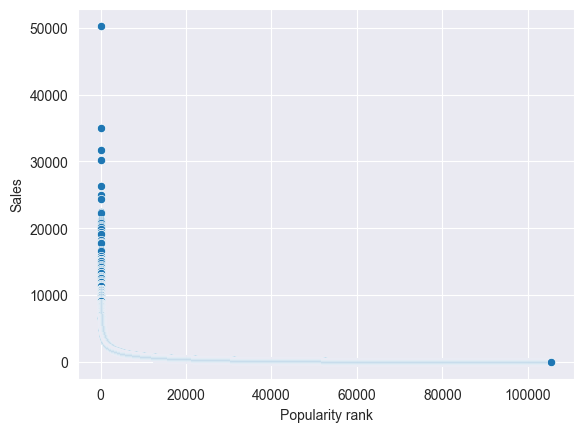

,article_id,sales_count
0,706016001,50287.0
1,706016002,35043.0
2,372860001,31718.0
3,610776002,30199.0
4,759871002,26329.0
...,...,...
105537,926010001,0.0
105538,896195002,0.0
105539,917203001,0.0
105540,917203003,0.0


In [176]:
sns.scatterplot(y=sorted_articles["sales_count"], x=sorted_articles.index)
# plt.gca().invert_xaxis()  # To reverse the x-axis

plt.xlabel("Popularity rank")
plt.ylabel("Sales")
plt.show()

plt.show()
sorted_articles

The scatterplot shows us that there's a select few in the short head part, while a huge amount is in the long tail part.

# Radek's preprocessing

In this section, I will be swapping Short Head candidates with Long Tail ones 

In [177]:
test_week = transactions.week.max() + 1
transactions = transactions[transactions.week > transactions.week.max() - 10]

## Generating candidates

### Last purchase candidates

In [178]:
%%time

c2weeks = transactions.groupby('customer_id')['week'].unique()

CPU times: total: 11 s
Wall time: 11 s


In [179]:
transactions.groupby('week')['t_dat'].agg(['min', 'max'])


,min,max
week,,
95,2020-07-15,2020-07-21
96,2020-07-22,2020-07-28
97,2020-07-29,2020-08-04
98,2020-08-05,2020-08-11
99,2020-08-12,2020-08-18
100,2020-08-19,2020-08-25
101,2020-08-26,2020-09-01
102,2020-09-02,2020-09-08
103,2020-09-09,2020-09-15


In [180]:
c2weeks

customer_id
28847241659200          [95, 96, 101, 102]
41318098387474                        [98]
116809474287335                 [101, 103]
200292573348128          [95, 96, 99, 102]
248294615847351                       [96]
                               ...        
18446624797007271432                  [95]
18446630855572834764                 [103]
18446662237889060501                 [100]
18446705133201055310                 [102]
18446737527580148316                 [104]
Name: week, Length: 437365, dtype: object

In [181]:
%%time

c2weeks2shifted_weeks = {}

for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}
    for i in range(weeks.shape[0]-1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week

CPU times: total: 750 ms
Wall time: 859 ms


In [182]:
c2weeks2shifted_weeks[28847241659200]

{95: 96, 96: 101, 101: 102, 102: 105}

In [183]:
candidates_last_purchase = transactions.copy()


In [184]:
%%time

weeks = []
for i, (c_id, week) in enumerate(zip(transactions['customer_id'], transactions['week'])):
    weeks.append(c2weeks2shifted_weeks[c_id][week])
    
candidates_last_purchase.week=weeks

CPU times: total: 13.3 s
Wall time: 13.3 s


In [185]:
candidates_last_purchase[candidates_last_purchase['customer_id']==272412481300040]

,t_dat,customer_id,article_id,price,sales_channel_id,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,96
29030504,2020-07-15,272412481300040,816592008,0.016932,1,96
29030505,2020-07-15,272412481300040,621381021,0.033881,1,96
29030506,2020-07-15,272412481300040,817477003,0.025407,1,96
29030507,2020-07-15,272412481300040,899088002,0.025407,1,96
29319533,2020-07-22,272412481300040,885077001,0.008458,1,103
29410772,2020-07-24,272412481300040,850176003,0.029034,2,103
29410773,2020-07-24,272412481300040,875803001,0.064559,2,103
29410774,2020-07-24,272412481300040,892970003,0.020966,2,103
29410775,2020-07-24,272412481300040,854619003,0.020966,2,103


In [186]:
transactions[transactions['customer_id']==272412481300040]

,t_dat,customer_id,article_id,price,sales_channel_id,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95
29030504,2020-07-15,272412481300040,816592008,0.016932,1,95
29030505,2020-07-15,272412481300040,621381021,0.033881,1,95
29030506,2020-07-15,272412481300040,817477003,0.025407,1,95
29030507,2020-07-15,272412481300040,899088002,0.025407,1,95
29319533,2020-07-22,272412481300040,885077001,0.008458,1,96
29410772,2020-07-24,272412481300040,850176003,0.029034,2,96
29410773,2020-07-24,272412481300040,875803001,0.064559,2,96
29410774,2020-07-24,272412481300040,892970003,0.020966,2,96
29410775,2020-07-24,272412481300040,854619003,0.020966,2,96


### Bestsellers candidates

In [187]:
mean_price = transactions \
.groupby(['week', 'article_id'])['price'].mean()

In [188]:
mean_price

week  article_id
95    108775015     0.004729
      108775044     0.008458
      110065001     0.006085
      110065002     0.006085
      111565001     0.004288
                      ...   
104   952267001     0.013732
      952938001     0.048651
      953450001     0.016932
      953763001     0.021885
      956217002     0.059068
Name: price, Length: 196880, dtype: float32

In [189]:
sales = transactions \
    .groupby('week')['article_id'].value_counts() \
    .groupby('week').rank(method='dense', ascending=False) \
    .groupby('week').head(12).rename('bestseller_rank').astype('int8')

In [190]:
sales

week  article_id
95    760084003      1
      866731001      2
      600886001      3
      706016001      4
      372860002      5
                    ..
104   915529003      8
      915529005      9
      448509014     10
      762846027     11
      714790020     12
Name: bestseller_rank, Length: 120, dtype: int8

In [191]:
sales_frame = sales.to_frame().reset_index() # DataFrame is easier to use than Series (from Radek), so I'll use this from now on

### Diversity before

I'll measure diversity using Jaccard index

In [192]:
def jaccard_diversity(list1, list2):
    intersection = len(list1.intersection(list2))
    union = len(list1.union(list2))
    jaccard_index = intersection / union
    diversity_index = 1 - jaccard_index
    return diversity_index

def avg_jaccard_diversity(df, weeks_list): # only computes diversity with next week (chain)
    jaccard_sum = 0
    pair_count = 0

    for i, week1 in enumerate(weeks_list):
        article_ids1 = set(df[df["week"] == week1]["article_id"])
        if week1 == weeks_list.max():
            break
        week2 = week1 + 1
        article_ids2 = set(df[df["week"] == week2]["article_id"])
        diversity_index = jaccard_diversity(article_ids1, article_ids2)
        print(f"{week1}, {week2}: {diversity_index}")
        jaccard_sum += diversity_index
        pair_count += 1
    average_jaccard = jaccard_sum / pair_count
    print(f"Average diversity: {average_jaccard}")


weeks_list = sales_frame["week"].unique()

avg_jaccard_diversity(sales_frame, weeks_list)

95, 96: 0.736842105263158
96, 97: 0.8571428571428572
97, 98: 1.0
98, 99: 1.0
99, 100: 0.8
100, 101: 0.736842105263158
101, 102: 0.5882352941176471
102, 103: 0.8571428571428572
103, 104: 0.5882352941176471
Average diversity: 0.7960489458941472


When we replace a short head item, diversity is bound to increase (assuming we don't recommend the same Long Tail item twice within 2 weeks)

In [193]:
def increase_diversity(df, weeks_list, K):
    top_long_tail = articles[articles["long_tail"]==1][["article_id", "sales_count"]].head(200).sort_values(by="sales_count", ascending=False)
    top_long_tail.reset_index(inplace=True)
    long_tail_index = 0 # start from most popular
    for i, week1 in enumerate(weeks_list):
        article_ids1 = set(df[df["week"] == week1]["article_id"])
        if week1 == weeks_list.max():
            break
        week2 = week1 + 1
        items_left = K
        article_ids2 = set(df[df["week"] == week2]["article_id"])
        curr_diversity_index = jaccard_diversity(article_ids1, article_ids2)

        for j, item in df[df["week"]==week1].iterrows(): # edit items one by one until K items edited or diversity maximized
            if items_left == 0:
                break
            old_item = df.at[j, "article_id"]
            new_item = top_long_tail.at[long_tail_index, "article_id"]
            df.at[j, "article_id"] = new_item
            items_left -= 1
            long_tail_index += 1
            diversity_index = jaccard_diversity(article_ids1, article_ids2) # diversity is always going to increase, because it contains no long tail items
            if diversity_index == 1.0 or items_left == 0: # good, no replacement needed
                break
    return df

sales_frame = increase_diversity(sales_frame, weeks_list, K=K)

sales_frame

,week,article_id,bestseller_rank
0,95,189616008,1
1,95,866731001,2
2,95,600886001,3
3,95,706016001,4
4,95,372860002,5
...,...,...,...
115,104,915529003,8
116,104,915529005,9
117,104,448509014,10
118,104,762846027,11


In [194]:
avg_jaccard_diversity(sales_frame, weeks_list)

95, 96: 0.8571428571428572
96, 97: 0.9565217391304348
97, 98: 1.0
98, 99: 1.0
99, 100: 0.8571428571428572
100, 101: 0.736842105263158
101, 102: 0.6666666666666667
102, 103: 0.8571428571428572
103, 104: 0.6666666666666667
Average diversity: 0.8442361943506108


### Personalizing candidates: KNN

We now have the personalize these candidates for users who bought item(s) previously. Radek uses popular items from the test week to recommend to all users, even those who didn't have make purchases, hence the candidate generation for the test week will remain unchanged.

In [195]:
transactions

,t_dat,customer_id,article_id,price,sales_channel_id,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95
29030504,2020-07-15,272412481300040,816592008,0.016932,1,95
29030505,2020-07-15,272412481300040,621381021,0.033881,1,95
29030506,2020-07-15,272412481300040,817477003,0.025407,1,95
29030507,2020-07-15,272412481300040,899088002,0.025407,1,95
...,...,...,...,...,...,...
31774722,2020-09-22,18439937050817258297,891591003,0.084729,2,104
31774723,2020-09-22,18439937050817258297,869706005,0.084729,2,104
31779097,2020-09-22,18440902715633436014,918894002,0.016932,1,104
31779098,2020-09-22,18440902715633436014,761269001,0.016932,1,104


In [196]:
top_long_tail = articles[articles["long_tail"]==1][["article_id", "sales_count"]].sort_values(by="sales_count", ascending=False).head(1000).reset_index()
# top_long_tail.reset_index(inplace=True)
top_long_tail_interactions = top_long_tail.merge(transactions[["article_id", "customer_id", "week"]], on='article_id', how='inner') # inner to drop rows when no article match found

top_long_tail_interactions

,index,article_id,sales_count,customer_id,week
0,22465,598755001,5000.0,1155273576847131497,95
1,22465,598755001,5000.0,2593922373982065886,95
2,22465,598755001,5000.0,2683969249742094143,95
3,22465,598755001,5000.0,8458578397382596872,95
4,22465,598755001,5000.0,13467842284602600397,95
...,...,...,...,...,...
232399,91590,850259002,2757.0,2154919872542929560,101
232400,91590,850259002,2757.0,1660045867611861065,102
232401,91590,850259002,2757.0,10604618731655969063,102
232402,91590,850259002,2757.0,5194179330490702485,104


To make this computationally less expensive, I will take the most popular long tail item purchase per user

In [197]:
top_long_tail_interactions = top_long_tail_interactions.groupby(["customer_id", "week"]).head(1)

Now we have a list of top long tail purchases per user and week. For example, a user bought 2 items part of the top 1000 in 2 different weeks:

In [198]:
top_long_tail_interactions


,index,article_id,sales_count,customer_id,week
0,22465,598755001,5000.0,1155273576847131497,95
1,22465,598755001,5000.0,2593922373982065886,95
2,22465,598755001,5000.0,2683969249742094143,95
3,22465,598755001,5000.0,8458578397382596872,95
4,22465,598755001,5000.0,13467842284602600397,95
...,...,...,...,...,...
232397,91590,850259002,2757.0,296676015814588384,101
232398,91590,850259002,2757.0,5474775927656454007,101
232400,91590,850259002,2757.0,1660045867611861065,102
232402,91590,850259002,2757.0,5194179330490702485,104


In [199]:
top_long_tail_interactions[top_long_tail_interactions["week"]==96]["customer_id"].value_counts()


customer_id
107976824977578409      1
1493321412182594709     1
6567960287277251826     1
5461328346560079022     1
3961462986099231551     1
                       ..
11570700679734721851    1
9570722601438353771     1
8428218764679667865     1
8226560039654604435     1
17882518856805427118    1
Name: count, Length: 20255, dtype: int64

In [200]:
transactions[transactions["customer_id"]==107976824977578416]

,t_dat,customer_id,article_id,price,sales_channel_id,week


### K-Nearest Neighbours

We will replace top k bestseller items with k personalized long tail items.

Step 1: Create user-item interaction matrix

In [201]:
# interaction matrix will give cell a value of 1 if user interacted with an item
top_long_tail_interactions_matrix=top_long_tail_interactions.pivot_table(index="article_id", columns="customer_id", aggfunc=lambda x: 1, fill_value=0) 
top_long_tail_interactions_matrix

index                                            \
customer_id 200292573348128      248294615847351      272412481300040        
article_id                                                                   
111565001                      0                    0                    0   
111609001                      0                    0                    0   
153115019                      0                    0                    0   
153115020                      0                    0                    0   
182909001                      0                    0                    0   
...                          ...                  ...                  ...   
883033001                      0                    0                    0   
883033002                      0                    0                    0   
915526001                      0                    0                    0   
916468003                      0                    0                    0   
918292001                      0                    0                    0   

                                                                            \
customer_id 330092272649261      366493139417506      745180086074610        
article_id                                                                   
111565001                      0                    0                    0   
111609001                      0                    0                    0   
153115019                      0                    0                    0   
153115020                      0                    0                    1   
182909001                      0                    0                    0   
...                          ...                  ...                  ...   
883033001                      0                    0                    0   
883033002                      0                    0                    0   
915526001                      0                    0                    0   
916468003                      0                    0                    0   
918292001                      0                    0                    0   

                                                                            \
customer_id 857913002275398      879819981624203      1037449031262554       
article_id                                                                   
111565001                      0                    0                    0   
111609001                      0                    0                    0   
153115019                      0                    0                    0   
153115020                      0                    0                    0   
182909001                      0                    0                    0   
...                          ...                  ...                  ...   
883033001                      0                    0                    0   
883033002                      0                    0                    0   
915526001                      0                    0                    0   
916468003                      0                    0                    0   
918292001                      0                    0                    0   

                                  ...                 week  \
customer_id 1083424902212452      ... 18445164350380731040   
article_id                        ...                        
111565001                      0  ...                    0   
111609001                      0  ...                    0   
153115019                      0  ...                    0   
153115020                      0  ...                    0   
182909001                      0  ...                    0   
...                          ...  ...                  ...   
883033001                      0  ...                    0   
883033002                      0  ...                    0   
915526001                      0  ...                    0   
9164

Amount of 1's in matrix:

In [202]:
top_long_tail_interactions_matrix.values.sum()

479463

Step 2: calculate cosine similarities

In [203]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import numpy as np

KNN = NearestNeighbors(algorithm="brute", metric="cosine").fit(csr_matrix(top_long_tail_interactions_matrix)) # huge increase in speed when using csr_matrix!
top_long_tail_interactions_matrix

index                                            \
customer_id 200292573348128      248294615847351      272412481300040        
article_id                                                                   
111565001                      0                    0                    0   
111609001                      0                    0                    0   
153115019                      0                    0                    0   
153115020                      0                    0                    0   
182909001                      0                    0                    0   
...                          ...                  ...                  ...   
883033001                      0                    0                    0   
883033002                      0                    0                    0   
915526001                      0                    0                    0   
916468003                      0                    0                    0   
918292001                      0                    0                    0   

                                                                            \
customer_id 330092272649261      366493139417506      745180086074610        
article_id                                                                   
111565001                      0                    0                    0   
111609001                      0                    0                    0   
153115019                      0                    0                    0   
153115020                      0                    0                    1   
182909001                      0                    0                    0   
...                          ...                  ...                  ...   
883033001                      0                    0                    0   
883033002                      0                    0                    0   
915526001                      0                    0                    0   
916468003                      0                    0                    0   
918292001                      0                    0                    0   

                                                                            \
customer_id 857913002275398      879819981624203      1037449031262554       
article_id                                                                   
111565001                      0                    0                    0   
111609001                      0                    0                    0   
153115019                      0                    0                    0   
153115020                      0                    0                    0   
182909001                      0                    0                    0   
...                          ...                  ...                  ...   
883033001                      0                    0                    0   
883033002                      0                    0                    0   
915526001                      0                    0                    0   
916468003                      0                    0                    0   
918292001                      0                    0                    0   

                                  ...                 week  \
customer_id 1083424902212452      ... 18445164350380731040   
article_id                        ...                        
111565001                      0  ...                    0   
111609001                      0  ...                    0   
153115019                      0  ...                    0   
153115020                      0  ...                    0   
182909001                      0  ...                    0   
...                          ...  ...                  ...   
883033001                      0  ...                    0   
883033002                      0  ...                    0   
915526001                      0  ...                    0   
9164

Step 3: personalize k bestseller items

Since it's item-to-item, items will be similar to each other no matter the user. This makes computation less expensive.

In [204]:
unique_top_long_tail = top_long_tail_interactions["article_id"].unique()
unique_top_long_tail

array([598755001, 590928023, 224606019, 756633001, 659832001, 624486002,
       559630013, 457892003, 490176001, 448515001, 658030006, 827635001,
       805000001, 827411001, 111565001, 769748002, 590928022, 579541004,
       682550001, 697054003, 559630026, 711053009, 429313006, 568808001,
       561445006, 603145001, 783346020, 757915002, 688537012, 742933003,
       859125001, 794575001, 817472002, 599580046, 759482001, 758050001,
       832361002, 243937001, 733267001, 519583008, 189616001, 685813002,
       762063001, 529008045, 599580028, 752814004, 652924004, 562245093,
       562245064, 373506001, 717884003, 729860002, 711440001, 599580041,
       697091007, 720504001, 536139010, 736681001, 713253003, 664074007,
       733803001, 458543001, 573716049, 692226003, 700758001, 557994003,
       351484027, 852174001, 809961002, 399136011, 399223035, 883033002,
       832330002, 742916002, 351484033, 688873002, 507883014, 736681002,
       715624011, 484205004, 754404006, 583534002, 

In [205]:
def get_k_similar_long_tail_items(article_id, k):

    query_item_index = top_long_tail_interactions_matrix.index.get_loc(article_id)
    query_item_vector = top_long_tail_interactions_matrix.values[query_item_index].reshape(1, -1)
    
    distances, indices = KNN.kneighbors(query_item_vector, n_neighbors=k)
    nearest_neighbors_indices = indices.flatten()[1:]  # Exclude the first element (the user itself)
    nearest_neighbor_ids = top_long_tail_interactions_matrix.iloc[nearest_neighbors_indices].index
    
    return nearest_neighbor_ids.tolist()


In [206]:
similar_long_tail_items = []

for article_id in unique_top_long_tail:
    similar_items = get_k_similar_long_tail_items(article_id, K+1)
    # for similar_item in similar_items:
    #     similar_long_tail_items.append({'article_id': article_id, 'similar_article_id': similar_item})
    similar_long_tail_items.append({'article_id': article_id, 'similar_article_id': similar_items})

similar_long_tail_items = pd.DataFrame(similar_long_tail_items)
similar_long_tail_items

,article_id,similar_article_id
0,598755001,[598755002]
1,590928023,[712924014]
2,224606019,[716671001]
3,756633001,[799417001]
4,659832001,[452618001]
...,...,...
830,730863005,[685816004]
831,656719005,[762656002]
832,744862001,[678342028]
833,685816008,[857812004]


In [207]:
bestsellers_previous_week = pd.merge(sales_frame, mean_price, on=['week', 'article_id']).reset_index()
bestsellers_previous_week.week += 1

In [208]:
bestsellers_previous_week

,index,week,article_id,bestseller_rank,price
0,0,96,866731001,2,0.024919
1,1,96,600886001,3,0.022980
2,2,96,706016001,4,0.033197
3,3,96,372860002,5,0.013193
4,4,96,610776002,6,0.008318
...,...,...,...,...,...
114,114,105,915529003,8,0.033439
115,115,105,915529005,9,0.033417
116,116,105,448509014,10,0.041630
117,117,105,762846027,11,0.025005


In [209]:
unique_transactions = transactions \
    .groupby(['week', 'customer_id']) \
    .head(1) \
    .drop(columns=['article_id', 'price']) \
    .copy()

# unique transactions will only contain users that never made long tail item purchases within 10 weeks.
# Since we cannot personalize for those, they will simply merge with bestseller items.
unique_transactions_not_personalized = unique_transactions[~unique_transactions["customer_id"].isin(top_long_tail_interactions["customer_id"])]

In [210]:
unique_transactions_not_personalized

,t_dat,customer_id,sales_channel_id,week
29067103,2020-07-15,2133687643102426,2,95
29027487,2020-07-15,6010692573790711,1,95
29030261,2020-07-15,6434044519214559,2,95
29066471,2020-07-15,7678388473497046,2,95
29045989,2020-07-15,9033460998303010,1,95
...,...,...,...,...
31782717,2020-09-22,18432411165497420051,1,104
31777299,2020-09-22,18432753550436772025,2,104
31760188,2020-09-22,18435221511488011015,1,104
31787251,2020-09-22,18437941771381362708,2,104


In [211]:
transactions.drop_duplicates(['week', 'customer_id'])

,t_dat,customer_id,article_id,price,sales_channel_id,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95
29064059,2020-07-15,1456826891333599,888294001,0.013542,1,95
29067103,2020-07-15,2133687643102426,843642001,0.042356,2,95
29027487,2020-07-15,6010692573790711,857812010,0.039661,1,95
29046403,2020-07-15,6171059100114610,815447007,0.006763,2,95
...,...,...,...,...,...,...
31760188,2020-09-22,18435221511488011015,573085055,0.033881,1,104
31782234,2020-09-22,18436859303155335645,801447001,0.030492,1,104
31787251,2020-09-22,18437941771381362708,907188001,0.050831,2,104
31776022,2020-09-22,18438270306572912089,751471043,0.033881,1,104


In [212]:
# candidate bestsellers for users we cannot generate personalized candidates for
candidates_bestsellers = pd.merge(
    unique_transactions_not_personalized,
    bestsellers_previous_week,
    on='week',
)
candidates_bestsellers

,t_dat,customer_id,sales_channel_id,week,index,article_id,bestseller_rank,price
0,2020-07-22,649760207043851,1,96,0,866731001,2,0.024919
1,2020-07-22,649760207043851,1,96,1,600886001,3,0.022980
2,2020-07-22,649760207043851,1,96,2,706016001,4,0.033197
3,2020-07-22,649760207043851,1,96,3,372860002,5,0.013193
4,2020-07-22,649760207043851,1,96,4,610776002,6,0.008318
...,...,...,...,...,...,...,...,...
4923168,2020-09-22,18440902715633436014,1,104,102,918292001,8,0.041424
4923169,2020-09-22,18440902715633436014,1,104,103,762846027,9,0.025104
4923170,2020-09-22,18440902715633436014,1,104,104,809238005,10,0.041656
4923171,2020-09-22,18440902715633436014,1,104,105,673677002,11,0.024925


In [213]:
top_long_tail_interactions[top_long_tail_interactions["week"]==96]

,index,article_id,sales_count,customer_id,week
31,22465,598755001,5000.0,107976824977578409,96
32,22465,598755001,5000.0,2439403413560584179,96
33,22465,598755001,5000.0,7277307652190892760,96
34,22465,598755001,5000.0,9442157838157959436,96
35,22465,598755001,5000.0,10542420106459276787,96
...,...,...,...,...,...
232251,91590,850259002,2757.0,8585022613676459629,96
232252,91590,850259002,2757.0,11519808411186093891,96
232253,91590,850259002,2757.0,16724823495123755397,96
232255,91590,850259002,2757.0,17006265333647032764,96


In [214]:
top_long_tail_interactions[top_long_tail_interactions["week"]==96]["article_id"].value_counts()

article_id
730683050    358
706016038    221
866383006    177
816423004    174
832453005    171
            ... 
562252039      1
599580049      1
783440002      1
857880001      1
697054015      1
Name: count, Length: 695, dtype: int64

In [215]:
unique_transactions[unique_transactions["week"]==96]

,t_dat,customer_id,sales_channel_id,week
29334775,2020-07-22,200292573348128,2,96
29330872,2020-07-22,248294615847351,1,96
29319533,2020-07-22,272412481300040,1,96
29357168,2020-07-22,649760207043851,1,96
29324267,2020-07-22,2269719878901327,1,96
...,...,...,...,...
29602896,2020-07-28,18437287698903424427,1,96
29579216,2020-07-28,18442208713248673405,2,96
29601372,2020-07-28,18443005737395567187,1,96
29589628,2020-07-28,18443721675496509156,2,96


### Generating personalized candidates

In [216]:
# transactions of customers that purchased long tail item within 10 weeks
#unique_transactions_personalized = unique_transactions[unique_transactions["customer_id"].isin(top_long_tail_interactions["customer_id"])]
candidates_bestsellers_personalized = pd.DataFrame(columns=candidates_bestsellers.columns)
# for week in range (96, 105):
unique_long_tail_transactions_week = top_long_tail_interactions[top_long_tail_interactions["week"]==week]

# generate unpersonalized candidates for customers that did not make any long tail purchase in the current week
unique_transactions_week = unique_transactions[unique_transactions["week"]==week]
unique_transactions_week_not_purchased = unique_transactions_week[~unique_transactions_week["customer_id"].isin(unique_long_tail_transactions_week["customer_id"])]
unpersonalized_candidates_week = pd.merge( # matches all ids that didn't purchase in current week to the bestsellers for the same week
unique_transactions_week_not_purchased,
bestsellers_previous_week[bestsellers_previous_week["week"]==week],
on='week',
)
candidates_bestsellers_personalized = pd.concat([candidates_bestsellers_personalized, unpersonalized_candidates_week]) # gives warning, but safe to ignore

# generate personalized candidates for remaining customers who did makes purchases
unique_transactions_week_purchased = unique_long_tail_transactions_week
# we get the most popular Long Tail item bought by each customer
# unique_transactions_week_purchased = unique_transactions_week_purchased.merge(unique_transactions_week["customer_id"], on="customer_id", how="left")
# 
# replace the article_ids with top K similar ones
# these items are definitely in the similar_long_tail_items, since an interaction matrix was made for the top 1000 long tail items and the similarities were calculated
unique_transactions_week_purchased = unique_transactions_week_purchased.merge(similar_long_tail_items[["article_id", "similar_article_id"]], on="article_id", how="left")

# Since similar_article_id contains arrays, we now explode in order to get a seperate row for each array value
unique_transactions_week_purchased = unique_transactions_week_purchased.explode("similar_article_id")
# replace similar article id by article id, and delete original one
# unique_transactions_week_purchased = unique_transactions_week_purchased.drop(columns="article_id")
# unique_transactions_week_purchased = unique_transactions_week_purchased.rename(columns={"similar_article_id":"article_id"})

# add extra info used by Radek
personalized_customers_added_data = unique_long_tail_transactions_week.merge(unique_transactions[unique_transactions["week"]==week][["t_dat", "customer_id", "sales_channel_id"]], on="customer_id", how="left")

# first K bestsellers got replaced by personalized items per user, so slice K rows
remaining_bestsellers = bestsellers_previous_week[bestsellers_previous_week["week"]==week][K-1:].head(12-K)
remaining_candidates_week = pd.merge(
unique_long_tail_transactions_week[["customer_id", "week"]],
remaining_bestsellers,
on='week',
)

# personalized candidates by concat personalized and bestseller candidates together
candidates_bestsellers_personalized = pd.concat([candidates_bestsellers_personalized, unique_transactions_week_purchased])
candidates_bestsellers_personalized = pd.concat([candidates_bestsellers_personalized, remaining_candidates_week])
candidates_bestsellers_personalized = candidates_bestsellers_personalized.drop(columns=["sales_count"])
candidates_bestsellers_personalized["article_id"] = candidates_bestsellers_personalized["article_id"].astype("int32") # got converted to object, fix later
unique_transactions_week_purchased

C:\Users\guled\AppData\Local\Temp\ipykernel_17508\2036143937.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  candidates_bestsellers_personalized = pd.concat([candidates_bestsellers_personalized, unpersonalized_candidates_week]) # gives warning, but safe to ignore


,index,article_id,sales_count,customer_id,week,similar_article_id
0,22465,598755001,5000.0,7636828614367800812,104,598755002
1,22465,598755001,5000.0,16525959734502196750,104,598755002
2,22465,598755001,5000.0,286971730925296472,104,598755002
3,22465,598755001,5000.0,5244928710645076966,104,598755002
4,22465,598755001,5000.0,7443171947608403248,104,598755002
...,...,...,...,...,...,...
9983,38172,656719005,2759.0,6627814345272218069,104,762656002
9984,46432,685816008,2758.0,2179145031901605098,104,857812004
9985,46432,685816008,2758.0,7316578718749643934,104,857812004
9986,91590,850259002,2757.0,5194179330490702485,104,794320001


Article info gets added like Radek did

In [217]:
candidates_bestsellers_personalized = candidates_bestsellers_personalized.merge(articles[["article_id", "long_tail"]], on="article_id", how="left").drop(columns=["bestseller_rank"])
candidates_bestsellers_personalized

,t_dat,customer_id,sales_channel_id,week,index,article_id,price,similar_article_id,long_tail
0,2020-09-16,11484807043854349,1,104,95,186262006,0.003922,NaN,1
1,2020-09-16,11484807043854349,1,104,96,865799006,0.033340,NaN,1
2,2020-09-16,11484807043854349,1,104,97,918522001,0.041416,NaN,1
3,2020-09-16,11484807043854349,1,104,98,924243001,0.041549,NaN,1
4,2020-09-16,11484807043854349,1,104,99,448509014,0.041604,NaN,0
...,...,...,...,...,...,...,...,...,...
827803,NaT,7455250409495986129,NaN,104,101,809238001,0.041612,NaN,1
827804,NaT,7455250409495986129,NaN,104,102,918292001,0.041424,NaN,1
827805,NaT,7455250409495986129,NaN,104,103,762846027,0.025104,NaN,1
827806,NaT,7455250409495986129,NaN,104,104,809238005,0.041656,NaN,1


In [218]:
candidates_bestsellers_personalized.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 827808 entries, 0 to 827807
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   t_dat               707952 non-null  datetime64[us]
 1   customer_id         827808 non-null  object        
 2   sales_channel_id    707952 non-null  object        
 3   week                827808 non-null  object        
 4   index               827808 non-null  object        
 5   article_id          827808 non-null  int32         
 6   price               817820 non-null  float32       
 7   similar_article_id  9988 non-null    object        
 8   long_tail           827808 non-null  int32         
dtypes: datetime64[us](1), float32(1), int32(2), object(5)
memory usage: 47.4+ MB


In [219]:
test_set_transactions = unique_transactions_not_personalized.drop_duplicates('customer_id').reset_index(drop=True)
test_set_transactions.week = test_week

In [220]:
test_set_transactions

,t_dat,customer_id,sales_channel_id,week
0,2020-07-15,2133687643102426,2,105
1,2020-07-15,6010692573790711,1,105
2,2020-07-15,6434044519214559,2,105
3,2020-07-15,7678388473497046,2,105
4,2020-07-15,9033460998303010,1,105
...,...,...,...,...
297981,2020-09-22,18403657855694067653,2,105
297982,2020-09-22,18410229429441241008,2,105
297983,2020-09-22,18417769707947924979,2,105
297984,2020-09-22,18418054986721795659,2,105


In [221]:
bestsellers_previous_week.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            119 non-null    int64  
 1   week             119 non-null    int8   
 2   article_id       119 non-null    int32  
 3   bestseller_rank  119 non-null    int8   
 4   price            119 non-null    float32
dtypes: float32(1), int32(1), int64(1), int8(2)
memory usage: 2.2 KB


In [222]:
candidates_bestsellers_test_week = pd.merge(
    test_set_transactions,
    bestsellers_previous_week,
    on='week'
)

Bestsellers from test week get added to bestseller candidates of training weeks

In [223]:
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
candidates_bestsellers.drop(columns='bestseller_rank', inplace=True)

In [224]:
candidates_bestsellers
# candidates_bestsellers[candidates_bestsellers["article_id"] == 938182001]


,t_dat,customer_id,sales_channel_id,week,index,article_id,price
0,2020-07-22,649760207043851,1,96,0,866731001,0.024919
1,2020-07-22,649760207043851,1,96,1,600886001,0.022980
2,2020-07-22,649760207043851,1,96,2,706016001,0.033197
3,2020-07-22,649760207043851,1,96,3,372860002,0.013193
4,2020-07-22,649760207043851,1,96,4,610776002,0.008318
...,...,...,...,...,...,...,...
3575827,2020-09-22,18421175435799911749,2,105,114,915529003,0.033439
3575828,2020-09-22,18421175435799911749,2,105,115,915529005,0.033417
3575829,2020-09-22,18421175435799911749,2,105,116,448509014,0.041630
3575830,2020-09-22,18421175435799911749,2,105,117,762846027,0.025005


Article info gets added to bestseller candidates

In [225]:
candidates_bestsellers = candidates_bestsellers.merge(articles[["article_id"]], on="article_id", how="left")

Now we also add personalized candidates for users that bought atleast 1 Long Tail item

In [226]:
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_personalized])
candidates_bestsellers.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9326813 entries, 0 to 827807
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   t_dat               datetime64[us]
 1   customer_id         object        
 2   sales_channel_id    object        
 3   week                object        
 4   index               object        
 5   article_id          int32         
 6   price               float32       
 7   similar_article_id  object        
 8   long_tail           float64       
dtypes: datetime64[us](1), float32(1), float64(1), int32(1), object(5)
memory usage: 640.4+ MB


# Combining transactions and candidates / negative examples


In [227]:
transactions['purchased'] = 1


In [228]:
data = pd.concat([transactions, candidates_last_purchase, candidates_bestsellers])
data.purchased.fillna(0, inplace=True)

In [229]:
data

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,index,similar_article_id,long_tail
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95,1.0,NaN,NaN,NaN
29030504,2020-07-15,272412481300040,816592008,0.016932,1,95,1.0,NaN,NaN,NaN
29030505,2020-07-15,272412481300040,621381021,0.033881,1,95,1.0,NaN,NaN,NaN
29030506,2020-07-15,272412481300040,817477003,0.025407,1,95,1.0,NaN,NaN,NaN
29030507,2020-07-15,272412481300040,899088002,0.025407,1,95,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
827803,NaT,7455250409495986129,809238001,0.041612,NaN,104,0.0,101,NaN,1.0
827804,NaT,7455250409495986129,918292001,0.041424,NaN,104,0.0,102,NaN,1.0
827805,NaT,7455250409495986129,762846027,0.025104,NaN,104,0.0,103,NaN,1.0
827806,NaT,7455250409495986129,809238005,0.041656,NaN,104,0.0,104,NaN,1.0


In [230]:
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

In [231]:
data.purchased.mean()


0.18167212779029285

### Add bestseller information


In [232]:
data = pd.merge(
    data,
    bestsellers_previous_week[['week', 'article_id', 'bestseller_rank']],
    on=['week', 'article_id'],
    how='left'
)

In [233]:
data = data[data.week != data.week.min()]
data.bestseller_rank.fillna(999, inplace=True)

In [234]:
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')

In [235]:
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [236]:
train = data[data.week != test_week]
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()

In [237]:
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values

In [238]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

In [239]:
%%time

train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

CPU times: total: 250 ms
Wall time: 268 ms


In [240]:
# Model training


In [241]:
from lightgbm.sklearn import LGBMRanker

In [242]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

In [243]:
%%time

ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.847625
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.151249
[LightGBM] [Debug] init for col-wise cost 0.102437 seconds, init for row-wise cost 0.218168 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1087
[LightGBM] [Info] Number of data points in the train set: 8466302, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
CPU times: total: 14.9 s
Wall time: 2.73 s


In [244]:
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

bestseller_rank 0.992132055524303
product_type_no 0.002603688284212981
garment_group_no 0.001835166125638445
article_id 0.001834457698536654
age 0.0005034443055290727
department_no 0.00034357367570581656
postal_code 0.00026789692222995814
club_member_status 0.00015974561115068194
Active 9.009846880087734e-05
graphical_appearance_no 8.482889056551339e-05
section_no 7.280044969967128e-05
index_code 7.224404362737313e-05
FN 0.0
fashion_news_frequency 0.0
perceived_colour_master_id 0.0
perceived_colour_value_id 0.0
colour_group_code 0.0
index_group_no 0.0


# Calculate predictions

In [245]:
%time

test['preds'] = ranker.predict(test_X)

c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

bestsellers_last_week = \
    bestsellers_previous_week[bestsellers_previous_week.week == bestsellers_previous_week.week.max()]['article_id'].tolist()

CPU times: total: 0 ns
Wall time: 0 ns


In [246]:
bestsellers_last_week

[924243001,
 924243002,
 918522001,
 923758001,
 866731001,
 909370001,
 751471001,
 915529003,
 915529005,
 448509014,
 762846027,
 714790020]

# Create submission

In [247]:
sub = pd.read_csv(utils.path + "sample_submission.csv")

In [248]:
%%time
preds = []
for c_id in utils.customer_hex_id_to_int(sub.customer_id):
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + bestsellers_last_week
    preds.append(pred[:12])

CPU times: total: 4.03 s
Wall time: 6.41 s


In [249]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = preds

In [250]:
sub_name = "basic_model_submission_K" + str(K) + "_a" + str(alpha) + ".csv.gz"
sub.to_csv(f"{sub_name}", index=False)

# Evaluation

In [251]:
from create_validation import create_validation
from evaluation import eval_sub
create_validation()
print(sub_name)

basic_model_submission_K1_a5000.csv.gz


### MAP@12 score

In [252]:
from evaluation import eval_sub

MAP12_score = eval_sub(sub_name, "map", k=12)
print(MAP12_score)

0.9348744921602494


### Recall score

In [253]:
recall_score = eval_sub(sub_name, "recall", k=12)
print(recall_score)

0.04758695982656973
